# サマリ


前回から、モデルの追加、訓練誤差、汎化誤差の評価を行った。  
今後、モデルのパラメータ検証等を進めていきたい。

### 結果まとめ  
[結果まとめ](https://docs.google.com/spreadsheets/d/16RSC4ebjKEi8EzY9Ney37pXhJAB0jGhajYC0DkEbXYk/edit#gid=0)


# 必要モジュールのインポート

In [1]:
import numpy as np
print("numpy.version=" + np.__version__)
import pandas as pd
print("pandas.version=" + pd.__version__)
import sklearn as sk
print("sklearn.version=" + sk.__version__)
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler #正規化のためのライブラリ
from sklearn.preprocessing import StandardScaler #標準化のためのライブラリ
from scipy import integrate
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
print("matplotlib.version=" + mpl.__version__)
import seaborn as sns
print("seaborn.version=" + sns.__version__)
import pydotplus
import graphviz
print("graphviz.version=" + graphviz.__version__)
import tensorflow as tf
print("tensorflow.version=" + tf.__version__)
import keras
print("keras.version=" + keras.__version__)

import warnings
warnings.filterwarnings('ignore')

numpy.version=1.15.2
pandas.version=0.23.4
sklearn.version=0.19.1


C:\Users\nashi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


matplotlib.version=3.0.0
seaborn.version=0.9.0
graphviz.version=0.8.4


C:\Users\nashi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow.version=1.11.0
keras.version=2.2.4


Using TensorFlow backend.


# データのインポート
元データをdf0とする

In [2]:
df0 = pd.read_excel("measurements2.xlsx")
df0.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


# データの確認

In [3]:
print('dataframeの行数・列数の確認\n', df0.shape)
print("\n")
print('indexの確認\n', df0.index)
print("\n")
print('columnの確認\n', df0.columns)
print("\n")
print('dataframeの各列のデータ型を確認\n', df0.dtypes)

dataframeの行数・列数の確認
 (388, 12)


indexの確認
 RangeIndex(start=0, stop=388, step=1)


columnの確認
 Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters',
       'refill gas'],
      dtype='object')


dataframeの各列のデータ型を確認
 distance         float64
consume          float64
speed              int64
temp_inside      float64
temp_outside       int64
specials          object
gas_type          object
AC                 int64
rain               int64
sun                int64
refill liters    float64
refill gas        object
dtype: object


In [4]:
df0.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [5]:
#欠損値確認
df0.isnull().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

# データ前処理

In [6]:
#標準化関数
def SScaler(df):
    
    stdsc = StandardScaler()

    colnum = len(df.columns)

    for i in range(colnum):
        #consume以外を標準化
        if i != 1:
            df.iloc[:, [i]] = stdsc.fit_transform(df.iloc[:,[i]].values)

## データ１

In [7]:
#データフレームのコピーは、＝では、リンクとなってしまうため、copy()を使う
df1 = df0.copy()

### temp inside処理

In [8]:
df1.temp_inside.value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64

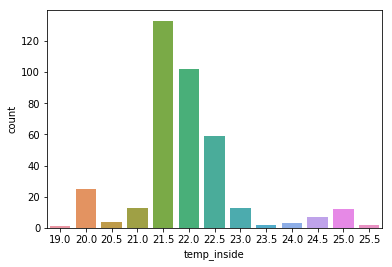

In [9]:
sns.countplot(x="temp_inside",data=df1)

In [10]:
print("tempinsitde平均値="+ str(df1.temp_inside.mean()))
print("tempinsitde中央値="+ str(df1.temp_inside.median()))

tempinsitde平均値=21.929521276595743
tempinsitde中央値=22.0


In [11]:
#temp_insideの欠損値を平均値で埋める
df1.temp_inside = df1.temp_inside.fillna(df1.temp_inside.mean())

### specials処理

In [12]:
df1.specials.unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [13]:
#名寄せ
df1['specials'] = df1['specials'].str.replace('sun ac', 'AC sun')
df1['specials'] = df1['specials'].str.replace('AC Sun', 'AC sun')
df1['specials'] = df1['specials'].str.replace('ac rain', 'AC rain')
df1['specials'] = df1['specials'].str.replace('ac', 'AC')

In [14]:
df1.specials.unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun'], dtype=object)

In [15]:
#specialsをダミー変数化
df1 = pd.get_dummies(df1, dummy_na=True,columns=['specials'])
df1.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill liters,refill gas,specials_AC,specials_AC rain,specials_AC snow,specials_AC sun,specials_half rain half sun,specials_rain,specials_snow,specials_sun,specials_nan
0,28.0,5.0,26,21.5,12,E10,0,0,0,45.0,E10,0,0,0,0,0,0,0,0,1
1,12.0,4.2,30,21.5,13,E10,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1
2,11.2,5.5,38,21.5,15,E10,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1
3,12.9,3.9,36,21.5,14,E10,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1
4,18.5,4.5,46,21.5,15,E10,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1


### gas type処理

In [16]:
df1.gas_type.unique()

array(['E10', 'SP98'], dtype=object)

In [17]:
#gas typeをダミー変数化
df1 = pd.get_dummies(df1,columns=["gas_type"])
df1.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,refill gas,...,specials_AC rain,specials_AC snow,specials_AC sun,specials_half rain half sun,specials_rain,specials_snow,specials_sun,specials_nan,gas_type_E10,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,45.0,E10,...,0,0,0,0,0,0,0,1,1,0
1,12.0,4.2,30,21.5,13,0,0,0,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0
2,11.2,5.5,38,21.5,15,0,0,0,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0
3,12.9,3.9,36,21.5,14,0,0,0,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0
4,18.5,4.5,46,21.5,15,0,0,0,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0


### refill liters処理

In [18]:
df1["refill liters"].unique()

array([45. ,  nan, 37.6, 37.7, 38. , 38.3, 10. , 39. , 41. , 37. , 37.2])

In [19]:
#ひとまず欠損値に0を置く
df1 = df1.fillna({'refill liters': 0})

In [20]:
df1["refill liters"].unique()

array([45. ,  0. , 37.6, 37.7, 38. , 38.3, 10. , 39. , 41. , 37. , 37.2])

### refill gas処理

In [21]:
df1["refill gas"].unique()

array(['E10', nan, 'SP98'], dtype=object)

In [22]:
df1 = pd.get_dummies(df1, dummy_na=True,columns=['refill gas'])
df1.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_AC,...,specials_half rain half sun,specials_rain,specials_snow,specials_sun,specials_nan,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,refill gas_nan
0,28.0,5.0,26,21.5,12,0,0,0,45.0,0,...,0,0,0,0,1,1,0,1,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0.0,0,...,0,0,0,0,1,1,0,0,0,1
2,11.2,5.5,38,21.5,15,0,0,0,0.0,0,...,0,0,0,0,1,1,0,0,0,1
3,12.9,3.9,36,21.5,14,0,0,0,0.0,0,...,0,0,0,0,1,1,0,0,0,1
4,18.5,4.5,46,21.5,15,0,0,0,0.0,0,...,0,0,0,0,1,1,0,0,0,1


In [23]:
#欠損値確認
df1.isnull().sum()

distance                       0
consume                        0
speed                          0
temp_inside                    0
temp_outside                   0
AC                             0
rain                           0
sun                            0
refill liters                  0
specials_AC                    0
specials_AC rain               0
specials_AC snow               0
specials_AC sun                0
specials_half rain half sun    0
specials_rain                  0
specials_snow                  0
specials_sun                   0
specials_nan                   0
gas_type_E10                   0
gas_type_SP98                  0
refill gas_E10                 0
refill gas_SP98                0
refill gas_nan                 0
dtype: int64

In [24]:
# 相関係数を確認
df1.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_AC,...,specials_half rain half sun,specials_rain,specials_snow,specials_sun,specials_nan,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,refill gas_nan
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.107045,0.038373,...,0.053996,0.010723,-0.029320,0.055737,-0.058454,0.053411,-0.053411,0.026079,0.106134,-0.100157
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,-0.074095,-0.042500,...,-0.010462,0.157122,0.021755,-0.168194,-0.020183,0.015327,-0.015327,-0.025731,-0.079080,0.078574
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,-0.007446,-0.060027,...,0.007756,0.038156,0.015635,0.033523,-0.042103,0.097360,-0.097360,-0.073428,0.046177,0.009556
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,-0.021348,0.312831,...,0.003606,-0.068993,0.095124,0.151238,-0.266888,-0.010198,0.010198,-0.014897,-0.017092,0.022834
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.041595,0.235493,...,-0.017168,-0.122726,-0.139378,0.300752,-0.184759,-0.148705,0.148705,-0.009135,-0.043809,0.040320
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,-0.052571,0.616618,...,-0.014715,-0.086790,-0.025553,-0.079168,-0.492968,-0.105285,0.105285,-0.033075,-0.042002,0.053898
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,0.033505,-0.072696,...,0.135289,0.797937,0.234936,-0.102757,-0.650855,-0.060328,0.060328,0.026474,0.055653,-0.060541
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,-0.054448,-0.058007,...,-0.015240,-0.089888,-0.026466,0.912175,-0.533973,-0.022761,0.022761,-0.034256,-0.043501,0.055822
refill liters,0.107045,-0.074095,-0.007446,-0.021348,-0.041595,-0.052571,0.033505,-0.054448,1.000000,-0.035136,...,0.065003,0.053644,-0.016031,-0.049666,0.023497,-0.000741,0.000741,0.640010,0.727194,-0.975377
specials_AC,0.038373,-0.042500,-0.060027,0.312831,0.235493,0.616618,-0.072696,-0.058007,-0.035136,1.000000,...,-0.009835,-0.058007,-0.017079,-0.052912,-0.344586,-0.105929,0.105929,-0.022106,-0.028073,0.036023


### データ1前処理まとめ
単純なダミー変数化、欠損値の埋めを行った。<br>
AC,rain,sunなど（specials含む）は欠損が多いため、0か欠損はわからない状態。<br>
refill literは一旦欠損値を0と置いたが、0なのか、欠損なのかはわからない状態。<br>
refill gasは、は欠損が多いため、0か欠損はわからない状態。

## データ２

In [25]:
#データ1をベースに、気温差、時間という変数を追加
df2 = df1.copy()
df2["tempdif"] = df2["temp_inside"] - df2["temp_outside"]
df2["time"] = df2["distance"] / df2["speed"]
df2.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_AC,...,specials_snow,specials_sun,specials_nan,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,refill gas_nan,tempdif,time
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.107045,0.038373,...,-0.029320,0.055737,-0.058454,0.053411,-0.053411,0.026079,0.106134,-0.100157,-0.080869,0.884942
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,-0.074095,-0.042500,...,0.021755,-0.168194,-0.020183,0.015327,-0.015327,-0.025731,-0.079080,0.078574,0.310991,-0.177825
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,-0.007446,-0.060027,...,0.015635,0.033523,-0.042103,0.097360,-0.097360,-0.073428,0.046177,0.009556,-0.007281,0.245061
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,-0.021348,0.312831,...,0.095124,0.151238,-0.266888,-0.010198,0.010198,-0.014897,-0.017092,0.022834,-0.226734,0.067038
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.041595,0.235493,...,-0.139378,0.300752,-0.184759,-0.148705,0.148705,-0.009135,-0.043809,0.040320,-0.990354,0.107179
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,-0.052571,0.616618,...,-0.025553,-0.079168,-0.492968,-0.105285,0.105285,-0.033075,-0.042002,0.053898,-0.130734,-0.009260
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,0.033505,-0.072696,...,0.234936,-0.102757,-0.650855,-0.060328,0.060328,0.026474,0.055653,-0.060541,0.188979,-0.027300
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,-0.054448,-0.058007,...,-0.026466,0.912175,-0.533973,-0.022761,0.022761,-0.034256,-0.043501,0.055822,-0.326104,0.058150
refill liters,0.107045,-0.074095,-0.007446,-0.021348,-0.041595,-0.052571,0.033505,-0.054448,1.000000,-0.035136,...,-0.016031,-0.049666,0.023497,-0.000741,0.000741,0.640010,0.727194,-0.975377,0.040244,0.150026
specials_AC,0.038373,-0.042500,-0.060027,0.312831,0.235493,0.616618,-0.072696,-0.058007,-0.035136,1.000000,...,-0.017079,-0.052912,-0.344586,-0.105929,0.105929,-0.022106,-0.028073,0.036023,-0.199341,0.094857


### データ２の前処理まとめ

データ１をベースに、以下の変数を追加<br>
tempdif・・・temp insideとtemp outsideの差をとる<br>
time・・・distanceをspeedで割る

## データ３

In [26]:
#データ３はデータ１を標準化
df3 = df1.copy()

SScaler(df3)

df3.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_AC,...,specials_half rain half sun,specials_rain,specials_snow,specials_sun,specials_nan,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,refill gas_nan
0,0.368714,5.0,-1.172804,-0.432382,0.091908,-0.28948,-0.375735,-0.299813,6.390062,-0.193476,...,-0.050833,-0.299813,-0.088273,-0.273482,0.561475,1.193734,-1.193734,8.752143,-0.145095,-5.370862
1,-0.338044,4.2,-0.878274,-0.432382,0.235123,-0.28948,-0.375735,-0.299813,-0.181605,-0.193476,...,-0.050833,-0.299813,-0.088273,-0.273482,0.561475,1.193734,-1.193734,-0.114258,-0.145095,0.186190
2,-0.373381,5.5,-0.289216,-0.432382,0.521552,-0.28948,-0.375735,-0.299813,-0.181605,-0.193476,...,-0.050833,-0.299813,-0.088273,-0.273482,0.561475,1.193734,-1.193734,-0.114258,-0.145095,0.186190
3,-0.298288,3.9,-0.436480,-0.432382,0.378338,-0.28948,-0.375735,-0.299813,-0.181605,-0.193476,...,-0.050833,-0.299813,-0.088273,-0.273482,0.561475,1.193734,-1.193734,-0.114258,-0.145095,0.186190
4,-0.050923,4.5,0.299843,-0.432382,0.521552,-0.28948,-0.375735,-0.299813,-0.181605,-0.193476,...,-0.050833,-0.299813,-0.088273,-0.273482,0.561475,1.193734,-1.193734,-0.114258,-0.145095,0.186190


## データ４

In [66]:
#
df4 = df2.copy()

df4["NewAC"] = df4["AC"]

df4.loc[(df4['tempdif'] < -15) , 'NewAC'] = 1
df4.loc[(df4['tempdif'] < -10) & (df4['tempdif'] > -15), 'NewAC'] = 0.66
df4.loc[(df4['tempdif'] < -5) & (df4['tempdif'] > -10), 'NewAC'] = 0.33
df4.loc[(df4['tempdif'] < 5) & (df4['tempdif'] > -5), 'NewAC'] = 0
df4.loc[(df4['tempdif'] < 10) & (df4['tempdif'] > 5), 'NewAC'] = 0.33
df4.loc[(df4['tempdif'] < 15) & (df4['tempdif'] > 10), 'NewAC'] = 0.66
df4.loc[(df4['tempdif'] > 15)  , 'NewAC'] = 3

df4.loc[df4['rain'] > 0, 'NewAC'] = 1
df4.loc[df4['specials_AC'] > 0, 'NewAC'] = 1
df4.loc[df4["specials_AC rain"] > 0, 'NewAC'] = 1
df4.loc[df4["specials_AC snow"] > 0, 'NewAC'] = 1
df4.loc[df4["specials_AC sun"] > 0, 'NewAC'] = 1
df4.loc[df4["specials_half rain half sun"] > 0, 'NewAC'] = 1
df4.loc[df4["specials_rain"] > 0, 'NewAC'] = 1
df4.loc[df4["specials_snow"] > 0, 'NewAC'] = 1



## モデル作成・検証（共通関数）

In [28]:
#スコア比較のためのデータ分割用関数
def Comparison(X, y):
    test_size = 0.1
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=1234)
    
    return X_train, X_test, y_train, y_test

In [29]:
#全データを使用した訓練誤差の確認用関数
def alldatascore(X_train, X_test, y_train, y_test, regr):
    print("\n■全データを使用した訓練誤差の確認(Trainで学習Testで評価)")

    # 値を予測
    y_pred = regr.predict(X_test)

    score = regr.score(X_train, y_train)
    print("訓練データscore = %s"%round(score,3) ) 
    
    score = regr.score(X_test, y_test)
    print("テストデータscore = %s"%round(score,3) )

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

In [30]:
#ホールドアウト法による訓練誤差、汎化誤差の評価用関数
def holdout(X, y, regr):
    print("\n■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)")
    
    # test_size = 0.1 # 全データのうち、何%をテストデータにするか（今回は10%～に設定）
    for test_size in np.arange(0.1,1,0.1):
        print("test_size=" + str(test_size))
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
    
        # 学習用データを使ってモデルを学習
        regr.fit(X_train, y_train)

        # 学習用データに対する予測を実行
        y_pred_train = regr.predict(X_train)

        # 学習データに対するMAEを計算（訓練誤差の評価）
        mae = mean_absolute_error(y_train, y_pred_train)
        print("学習データMAE(訓練誤差の評価) = %s"%round(mae,3) )

        # テストデータに対する予測を実行
        y_pred_test = regr.predict(X_test)

        # テストデータに対するMAEを計算（汎化誤差の評価）
        mae = mean_absolute_error(y_test, y_pred_test)
        print("テストデータMAE（汎化誤差の評価） = %s"%round(mae,3) )

In [31]:
#交差検証（クロスバリデーション）法による汎化誤差の評価
def CrossValidation(X, y, regr):
    print("\n■交差検証（クロスバリデーション）法による汎化誤差の評価（Trainをさらに分割)")
    
    n_split = 5 # グループ数を設定（今回は5分割）

    cross_valid_mae = 0
    split_num = 1

    # テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
        # 学習用データを使ってモデルを学習
        regr.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = regr.predict(X_test)
    
        # テストデータに対するMAEを計算
        mae = mean_absolute_error(y_test, y_pred_test)
        print("Fold %s"%split_num)
        print("MAE = %s"%round(mae, 3))
        print()
    
        cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_mae = cross_valid_mae / n_split
    print("Cross Validation MAE = %s"%round(final_mae, 3))    

In [32]:
#標準化
def SScaler(df):
    
    stdsc = StandardScaler()

    colnum = len(df.columns)

    for i in range(colnum):
        #consume以外を標準化
        if i != 1:
            df.iloc[:, [i]] = stdsc.fit_transform(df.iloc[:,[i]].values)
            
    

## モデル作成・検証（線形回帰モデル）

In [33]:
def ModelVerificationLinearRegression(X, y, df):
    print("\n【線形回帰モデル】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)
    
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    #説明変数の数
    exponum = len(xcol)

    # 重みを取り出す

    w0 = regr.intercept_

    #w1 = regr.coef_[0] w2=...
    #上記をfor文にする

    wall = []
    for i in range(exponum):
        wall.append(regr.coef_[i])
    
    #x1 = dfgus['distance'].values x2=...
    #上記をfor文にする

    xall = []
    for i in range(exponum):
        xall.append(df[xcol[i]].values)
    
    # 重みと二乗誤差の確認

    #y_est = w0 + w1 * x1 + w2 * x2 + w3* x3...
    #上記をfor文にする

    y_est = w0
    for i in range(exponum):
        y_est =  y_est + wall[i] * xall[i]
    
    squared_error = 0.5 * np.sum((y - y_est) ** 2)

    print("\n■重みの表示")
    print("W0=" + str(w0))
    for i in range(exponum):
        print("W"+ str(i+1) + "=" + str(wall[i]))
    
    print('二乗誤差 = {:.3f}'.format(squared_error))
    
    alldatascore(X_train, X_test, y_train, y_test, regr)
    holdout(X_train, y_train, regr)
    CrossValidation(X_train, y_train, regr)

In [34]:
#データ１全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationLinearRegression(X, y, df1)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【線形回帰モデル】

■重みの表示
W0=0.1405328517918658
W1=-0.0006973569740802312
W2=-0.01755764413367372
W3=-0.07547269402602953
W4=-0.04214832991023388
W5=-0.5716051833673017
W6=7.4600056259601
W7=2.751114476616867
W8=0.13846937228098585
W9=4.293417201488103
W10=-2.8179912184883538
W11=-1.2805227838177204
W12=2.1424998584614086
W13=0.49904030810398053
W14=-3.285221494231182
W15=-3.817645800698514
W16=0.6086146181554456
W17=3.6578093110268157
W18=0.02537727034529938
W19=-0.025377270345310964
W20=-2.0297726614988503
W21=-1.9161501589067964
W22=3.945922820405636
二乗誤差 = 141.290

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.357
テストデータscore = -0.282
MSE = 0.864
MA

In [35]:
#データ１相関が0.2以上の説明変数を選択
y = df1["consume"].values

xcol = ['speed', 'temp_outside','rain', ]

print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationLinearRegression(X, y, df1)

使用した説明変数
['speed', 'temp_outside', 'rain']

【線形回帰モデル】

■重みの表示
W0=6.165728251200862
W1=-0.01884908796611233
W2=-0.047579186549063214
W3=0.6000758266468688
二乗誤差 = 167.668

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.219
テストデータscore = -0.265
MSE = 0.853
MAE = 0.724
RMSE = 0.924

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.598
テストデータMAE（汎化誤差の評価） = 0.715
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.619
テストデータMAE（汎化誤差の評価） = 0.643
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.549
テストデータMAE（汎化誤差の評価） = 0.705
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.55
テストデータMAE（汎化誤差の評価） = 0.676
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.565
テストデータMAE（汎化誤差の評価） = 0.625
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.587
テストデータMAE（汎化誤差の評価） = 0.613
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.645
テストデータMAE（汎化誤差の評価） = 0.614
test_size=0.8
学習データMAE(訓練誤差の評価) = 0.687
テストデータMAE（汎化誤差の評価） = 0.618
test_size=0.9
学習データMAE(訓練誤差の評価) = 0.785
テストデータMAE（汎化誤差の評価） = 0.731

■交差検証（クロスバリデーション）法による汎化誤差の評価（Trainをさらに分割)
Fol

In [36]:
#データ２全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationLinearRegression(X, y, df2)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【線形回帰モデル】

■重みの表示
W0=2.32120075543809
W1=0.05153533578175763
W2=-0.04591856661778538
W3=-0.07698541476107978
W4=-0.058624802674281364
W5=-1.347049979318763
W6=7.425380562404209
W7=2.6511899483931867
W8=0.16219418822345605
W9=4.5486341911850685
W10=-2.5531467377576624
W11=-1.0325687944169955
W12=2.4284944545967955
W13=1.4982094595387765
W14=-3.818010732295625
W15=-4.382577891088019
W16=0.222695493796393
W17=3.088270556441254
W18=0.026433845153389222
W19=-0.026433845153399894
W20=-1.868787988234413
W21=-2.5400500152595584
W22=4.408838003493959
W23=-0.01836061208685453
W24=-3.3950840359868844
二乗誤差 = 121.541

■全データを使用した訓練誤差の確認(Trainで学習

In [37]:
#データ３全ての説明変数を使用したデータ
y = df3["consume"].values

xcol = df3.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df3[xcol].values

df3.head()
ModelVerificationLinearRegression(X, y, df3)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【線形回帰モデル】

■重みの表示
W0=4.909083857693889
W1=-0.01578719025436523
W2=-0.2384501612509762
W3=-0.07497330270098333
W4=-0.2943018398232776
W5=-0.15267452357625583
W6=2.456221375927962
W7=0.27491026286640957
W8=0.948179723041396
W9=0.4955922926483376
W10=-0.7057737387608755
W11=-0.1478741051263515
W12=0.25469552863305767
W13=-0.0576469743887731
W14=-1.3537639725550754
W15=-0.47769181360536445
W16=0.18431071781562608
W17=0.8630910689056996
W18=0.012492247945497408
W19=-0.012492247945497408
W20=-0.3382060440921201
W21=-0.4099756479937576
W22=0.5357203081705658
二乗誤差 = 141.290

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.357
テストデータscore = -0.282
MSE = 0.

In [81]:
#データ４絞った説明変数を選択
y = df4["consume"].values
print(df4.columns)

xcol = ['distance', "speed","temp_inside","temp_outside", "AC","rain","specials_AC rain","specials_rain","gas_type_E10","gas_type_SP98",'tempdif', "time", "NewAC" ]

print("使用した説明変数")
print(xcol)

X = df4[xcol].values

ModelVerificationLinearRegression(X, y, df4)

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'AC',
       'rain', 'sun', 'refill liters', 'specials_AC', 'specials_AC rain',
       'specials_AC snow', 'specials_AC sun', 'specials_half rain half sun',
       'specials_rain', 'specials_snow', 'specials_sun', 'specials_nan',
       'gas_type_E10', 'gas_type_SP98', 'refill gas_E10', 'refill gas_SP98',
       'refill gas_nan', 'tempdif', 'time', 'NewAC'],
      dtype='object')
使用した説明変数
['distance', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'specials_AC rain', 'specials_rain', 'gas_type_E10', 'gas_type_SP98', 'tempdif', 'time', 'NewAC']

【線形回帰モデル】

■重みの表示
W0=11.33467682046803
W1=0.05711393664984509
W2=-0.0500968643978464
W3=-0.12493932690906624
W4=-0.07199313662057999
W5=0.5246693477421084
W6=1.5146227943687565
W7=-1.4954851473043094
W8=-0.9170386693467741
W9=0.057313293992368695
W10=-0.057313293992366204
W11=-0.05294619028848298
W12=-3.5974566280080746
W13=0.1668365013224396
二乗誤差 = 136.443

■全データを使用した訓

## モデル作成・検証（Ridge）

In [38]:
def ModelVerificationRidge(X, y):
    print("\n【Ridge】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)
    
    alphas = [0.0, 1e-8, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
    for alpha in alphas:
        print("\n alpha=" + str(alpha))
        regr = Ridge(alpha=alpha)
        regr.fit(X_train, y_train)
        
        alldatascore(X_train, X_test, y_train, y_test, regr)
        holdout(X_train, y_train, regr)
        CrossValidation(X_train, y_train, regr)

In [39]:
#データ1全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationRidge(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【Ridge】

 alpha=0.0

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.344
テストデータscore = -0.276
MSE = 0.86
MAE = 0.763
RMSE = 0.928

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.546
テストデータMAE（汎化誤差の評価） = 569668813626.396
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.594
テストデータMAE（汎化誤差の評価） = 887940393025.389
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.546
テストデータMAE（汎化誤差の評価） = 738576999859.368
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.532
テストデータMAE（汎化誤差の評価） = 2172734674724.43
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.544
テストデータMAE（汎化誤差の評価） = 3274778415271.691
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.552
テストデータMAE（汎化誤差の評価） = 0.91
test_size=0.7

In [40]:
#データ2全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationRidge(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【Ridge】

 alpha=0.0

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.456
テストデータscore = -0.33
MSE = 0.897
MAE = 0.731
RMSE = 0.947

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.526
テストデータMAE（汎化誤差の評価） = 1198009252455.436
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.546
テストデータMAE（汎化誤差の評価） = 595355597081.517
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.515
テストデータMAE（汎化誤差の評価） = 1315223061552.09
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.509
テストデータMAE（汎化誤差の評価） = 791829581678.619
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.572
テストデータMAE（汎化誤差の評価） = 6188344924898.3
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.525
テストデータMAE（汎化誤差の評価） = 8

## モデル作成・検証（Lasso）

In [41]:
def ModelVerificationLasso(X, y):
    print("\n【Lasso】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)
    
    alphas = [0.0, 1e-8, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
    for alpha in alphas:
        print("\n alpha=" + str(alpha))
        regr = Lasso(alpha=alpha)
        regr.fit(X_train, y_train)
        
        alldatascore(X_train, X_test, y_train, y_test, regr)
        holdout(X_train, y_train, regr)
        CrossValidation(X_train, y_train, regr)

In [42]:
#データ1全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationLasso(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【Lasso】

 alpha=0.0

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.357
テストデータscore = -0.282
MSE = 0.864
MAE = 0.743
RMSE = 0.93

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.548
テストデータMAE（汎化誤差の評価） = 0.828
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.56
テストデータMAE（汎化誤差の評価） = 0.693
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.535
テストデータMAE（汎化誤差の評価） = 0.691
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.529
テストデータMAE（汎化誤差の評価） = 0.687
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.544
テストデータMAE（汎化誤差の評価） = 0.622
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.553
テストデータMAE（汎化誤差の評価） = 0.644
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.599
テストデータMAE（汎化誤差

In [43]:
#データ2全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationLasso(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【Lasso】

 alpha=0.0

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.463
テストデータscore = -0.352
MSE = 0.911
MAE = 0.725
RMSE = 0.955

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.523
テストデータMAE（汎化誤差の評価） = 0.85
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.537
テストデータMAE（汎化誤差の評価） = 0.686
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.517
テストデータMAE（汎化誤差の評価） = 0.682
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.512
テストデータMAE（汎化誤差の評価） = 0.677
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.525
テストデータMAE（汎化誤差の評価） = 0.62
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.526
テストデータMAE（汎化誤差の評価） = 0.645
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.

## モデル作成・検証（ElasticNet）

In [44]:
def ModelVerificationElasticNet(X, y):
    print("\n【ElasticNet】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)
    
    alpha = 1e-4 #正則化全体の強さを決定する
    l1_ratios = [0, 0.1, 0.5, 1.0] #L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）
    
    for l1_ratio in l1_ratios:
        print("l1_ratio=" + str(l1_ratio))
        regr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        regr.fit(X_train, y_train)
        
        alldatascore(X_train, X_test, y_train, y_test, regr)
        holdout(X_train, y_train, regr)
        CrossValidation(X_train, y_train, regr)

In [45]:
#データ1全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationElasticNet(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【ElasticNet】
l1_ratio=0

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.354
テストデータscore = -0.261
MSE = 0.85
MAE = 0.74
RMSE = 0.922

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.548
テストデータMAE（汎化誤差の評価） = 0.786
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.56
テストデータMAE（汎化誤差の評価） = 0.672
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.534
テストデータMAE（汎化誤差の評価） = 0.694
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.529
テストデータMAE（汎化誤差の評価） = 0.688
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.544
テストデータMAE（汎化誤差の評価） = 0.627
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.552
テストデータMAE（汎化誤差の評価） = 0.649
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.599
テストデータMAE（汎

## モデル作成・検証（多項式回帰モデル）

In [46]:
def ModelVerificationPolynomialFeatures(X, y, df):
    print("\n【多項式回帰モデル】")
    X1 = X
    y1 = y
    degrees = [0, 1, 2, 3, 4, 5]#degreeの値を指定する
    
    

    for degree in degrees:
        regr = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        regr.fit(X1, y1)

        # 値を予測
        y_pred = regr.predict(X1)

        score = regr.score(X1, y1)

        print("\n degree=" + str(degree))
        print("-----------------------------------------------------------")
        print("score = %s"%round(score,3) ) 

        # MSEを計算
        mse = mean_squared_error(y, y_pred) 
        print("MSE = %s"%round(mse,3) )  

        # MAEを計算
        mae = mean_absolute_error(y, y_pred) 
        print("MAE = %s"%round(mae,3) )

        # RMSEを計算
        rmse = np.sqrt(mse)
        print("RMSE = %s"%round(rmse, 3) )
        
        print("\n■ホールドアウト法による訓練誤差、汎化誤差の評価")
        X2 = X
        y2 = y
        # test_size = 0.1 # 全データのうち、何%をテストデータにするか（今回は10%～に設定）
        for test_size in np.arange(0.1,1,0.1):
            print("test_size=" + str(test_size))
    
            X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
    
            # 学習用データを使って多項式回帰モデルを学習
            regr2 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            regr2.fit(X2, y2)

            # 学習用データに対する予測を実行
            y_pred_train = regr2.predict(X_train)

            # 学習データに対するMAEを計算（訓練誤差の評価）
            mae = mean_absolute_error(y_train, y_pred_train)
            print("学習データMAE = %s"%round(mae,3) )

            # テストデータに対する予測を実行
            y_pred_test = regr2.predict(X_test)

            # テストデータに対するMAEを計算（汎化誤差の評価）
            mae = mean_absolute_error(y_test, y_pred_test)
            print("テストデータMAE = %s"%round(mae,3) )
        
        print("\n■交差検証（クロスバリデーション）法による汎化誤差の評価")
        X3 = X
        y3 = y   
        n_split = 5 # グループ数を設定（今回は5分割）

        cross_valid_mae = 0
        split_num = 1

        # テスト役を交代させながら学習と評価を繰り返す
        for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X3, y3):
            X_train, y_train = X[train_idx], y[train_idx] #学習用データ
            X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
            # 学習用データを使って多項式回帰モデルを学習
            regr3 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            regr3.fit(X3, y3)

            # テストデータに対する予測を実行
            y_pred_test = regr3.predict(X_test)
    
            # テストデータに対するMAEを計算
            mae = mean_absolute_error(y_test, y_pred_test)
            print("Fold %s"%split_num)
            print("MAE = %s"%round(mae, 3))
            print()
    
            cross_valid_mae += mae #後で平均を取るためにMAEを加算
            split_num += 1

        # MAEの平均値を最終的な汎化誤差値とする
        final_mae = cross_valid_mae / n_split
        print("Cross Validation MAE = %s"%round(final_mae, 3)) 
        

In [47]:
#全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

#ModelVerificationPolynomialFeatures(X, y, df1)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']


In [48]:
#データ１相関が0.2以上の説明変数を選択
y = df1["consume"].values

xcol = ['speed', 'temp_outside','rain', ]

print("使用した説明変数")
print(xcol)

X = df1[xcol].values

#ModelVerificationPolynomialFeatures(X, y, df1)

使用した説明変数
['speed', 'temp_outside', 'rain']


## モデル作成・検証（SVM）

In [49]:
def ModelVerificationSVM(X, y):
    print("\n【SVM】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)

    C = 5
    kernel = "rbf"
    gamma = 1
    regr = SVR(C=C, kernel=kernel, gamma=gamma)
    regr.fit(X_train, y_train)
    
    alldatascore(X_train, X_test, y_train, y_test, regr)
    holdout(X_train, y_train, regr)
    CrossValidation(X_train, y_train, regr)

In [50]:
#データ１全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationSVM(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【SVM】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.97
テストデータscore = -0.047
MSE = 0.706
MAE = 0.672
RMSE = 0.84

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.104
テストデータMAE（汎化誤差の評価） = 0.707
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.104
テストデータMAE（汎化誤差の評価） = 0.651
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.099
テストデータMAE（汎化誤差の評価） = 0.761
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.099
テストデータMAE（汎化誤差の評価） = 0.722
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.1
テストデータMAE（汎化誤差の評価） = 0.693
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.103
テストデータMAE（汎化誤差の評価） = 0.666
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.105
テストデータMAE（汎化誤差の評価） = 0.661
tes

In [51]:
#データ2全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationSVM(X, y)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【SVM】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.97
テストデータscore = -0.034
MSE = 0.697
MAE = 0.666
RMSE = 0.835

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.104
テストデータMAE（汎化誤差の評価） = 0.71
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.104
テストデータMAE（汎化誤差の評価） = 0.651
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.099
テストデータMAE（汎化誤差の評価） = 0.765
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.099
テストデータMAE（汎化誤差の評価） = 0.725
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.1
テストデータMAE（汎化誤差の評価） = 0.696
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.103
テストデータMAE（汎化誤差の評価） = 0.67
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.105
テストデータMAE（汎化誤

## モデル作成・検証（Random Forest）

In [52]:
def ModelVerificationRandomForest(X, y, df):
    print("\n【Random Forest】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)

    regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
    regr.fit(X_train, y_train)
    #RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
    #       max_features='auto', max_leaf_nodes=None,
    #       min_impurity_decrease=0.0, min_impurity_split=None,
    #       min_samples_leaf=1, min_samples_split=2,
    #       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
    #       oob_score=False, random_state=0, verbose=0, warm_start=False)
    alldatascore(X_train, X_test, y_train, y_test, regr)
    holdout(X_train, y_train, regr)
    CrossValidation(X_train, y_train, regr)   
    
    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
    print("\n■説明変数の重要度の確認")
    print("\n", regr.feature_importances_)
    pd.DataFrame(regr.feature_importances_, index=df.columns.name).plot.bar(figsize=(10,5))
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()
    
    

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【Random Forest】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.619
テストデータscore = 0.145
MSE = 0.576
MAE = 0.613
RMSE = 0.759

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.486
テストデータMAE（汎化誤差の評価） = 0.532
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.489
テストデータMAE（汎化誤差の評価） = 0.5
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.448
テストデータMAE（汎化誤差の評価） = 0.595
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.431
テストデータMAE（汎化誤差の評価） = 0.587
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.451
テストデータMAE（汎化誤差の評価） = 0.541
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.451
テストデータMAE（汎化誤差の評価） = 0.518
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.47
テストデータMAE（汎化誤差の評価） =

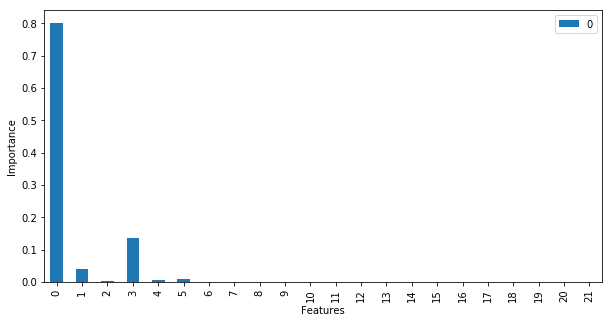

In [53]:
#データ１全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationRandomForest(X, y, df1)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【Random Forest】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.628
テストデータscore = 0.169
MSE = 0.56
MAE = 0.597
RMSE = 0.748

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.483
テストデータMAE（汎化誤差の評価） = 0.52
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.479
テストデータMAE（汎化誤差の評価） = 0.495
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.446
テストデータMAE（汎化誤差の評価） = 0.602
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.433
テストデータMAE（汎化誤差の評価） = 0.588
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.453
テストデータMAE（汎化誤差の評価） = 0.565
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.455
テストデータMAE（汎化誤差の評価） = 0.531
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.47
テス

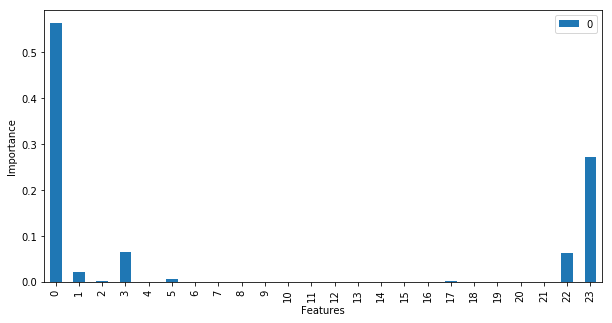

In [54]:
#データ2全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationRandomForest(X, y, df2)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time' 'NewAC']

【Random Forest】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.631
テストデータscore = 0.177
MSE = 0.555
MAE = 0.595
RMSE = 0.745

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.481
テストデータMAE（汎化誤差の評価） = 0.53
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.477
テストデータMAE（汎化誤差の評価） = 0.496
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.438
テストデータMAE（汎化誤差の評価） = 0.598
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.429
テストデータMAE（汎化誤差の評価） = 0.588
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.452
テストデータMAE（汎化誤差の評価） = 0.566
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.449
テストデータMAE（汎化誤差の評価） = 0.525
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) 

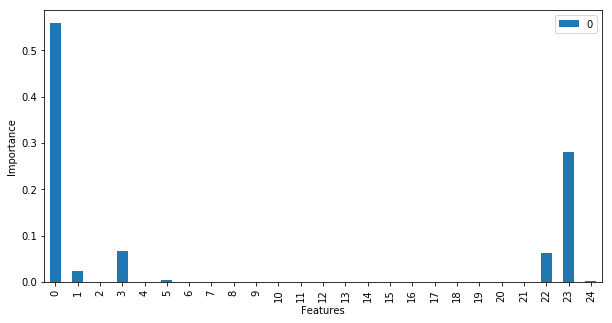

In [67]:
#データ4全ての説明変数を使用したデータ
y = df4["consume"].values

xcol = df4.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df4[xcol].values

ModelVerificationRandomForest(X, y, df4)

## モデル作成・検証（Adaboost）

In [56]:
def ModelVerificationAdaboost(X, y, df):
    print("\n【Adaboost】")
    
    #スコア比較のためのデータ分割
    X_train, X_test, y_train, y_test = Comparison(X, y)

    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3,
                                                   min_samples_leaf=2,
                                                   min_samples_split=2, 
                                                   random_state=1234,
                                                   criterion="mse"),
                                                   n_estimators=10, random_state=1234)
    
    regr.fit(X_train, y_train)
    
    alldatascore(X_train, X_test, y_train, y_test, regr)
    holdout(X_train, y_train, regr)
    CrossValidation(X_train, y_train, regr)  
    
    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
    print("\n■説明変数の重要度の確認")
    print("\n", regr.feature_importances_)
    pd.DataFrame(regr.feature_importances_, index=df.columns.name).plot.bar(figsize=(10,5))
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan']

【Adaboost】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.732
テストデータscore = 0.12
MSE = 0.593
MAE = 0.61
RMSE = 0.77

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.429
テストデータMAE（汎化誤差の評価） = 0.621
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.432
テストデータMAE（汎化誤差の評価） = 0.512
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.417
テストデータMAE（汎化誤差の評価） = 0.638
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.377
テストデータMAE（汎化誤差の評価） = 0.623
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.38
テストデータMAE（汎化誤差の評価） = 0.581
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.379
テストデータMAE（汎化誤差の評価） = 0.532
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.384
テストデータMAE（汎化誤差の評価） = 0.548

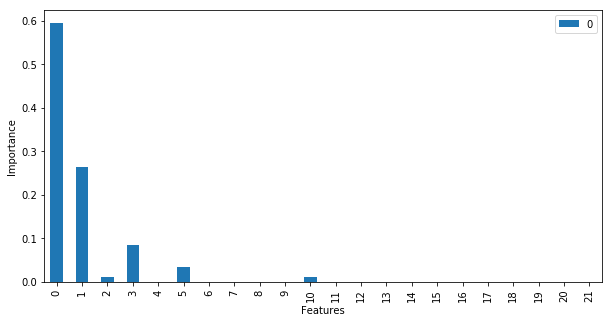

In [57]:
#データ１全ての説明変数を使用したデータ
y = df1["consume"].values

xcol = df1.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df1[xcol].values

ModelVerificationAdaboost(X, y, df1)

使用した説明変数
['distance' 'speed' 'temp_inside' 'temp_outside' 'AC' 'rain' 'sun'
 'refill liters' 'specials_AC' 'specials_AC rain' 'specials_AC snow'
 'specials_AC sun' 'specials_half rain half sun' 'specials_rain'
 'specials_snow' 'specials_sun' 'specials_nan' 'gas_type_E10'
 'gas_type_SP98' 'refill gas_E10' 'refill gas_SP98' 'refill gas_nan'
 'tempdif' 'time']

【Adaboost】

■全データを使用した訓練誤差の確認(Trainで学習Testで評価)
訓練データscore = 0.734
テストデータscore = 0.176
MSE = 0.556
MAE = 0.573
RMSE = 0.745

■ホールドアウト法による訓練誤差、汎化誤差の評価（Trainをさらに分割)
test_size=0.1
学習データMAE(訓練誤差の評価) = 0.434
テストデータMAE（汎化誤差の評価） = 0.543
test_size=0.2
学習データMAE(訓練誤差の評価) = 0.438
テストデータMAE（汎化誤差の評価） = 0.488
test_size=0.30000000000000004
学習データMAE(訓練誤差の評価) = 0.389
テストデータMAE（汎化誤差の評価） = 0.614
test_size=0.4
学習データMAE(訓練誤差の評価) = 0.371
テストデータMAE（汎化誤差の評価） = 0.589
test_size=0.5
学習データMAE(訓練誤差の評価) = 0.395
テストデータMAE（汎化誤差の評価） = 0.577
test_size=0.6
学習データMAE(訓練誤差の評価) = 0.382
テストデータMAE（汎化誤差の評価） = 0.561
test_size=0.7000000000000001
学習データMAE(訓練誤差の評価) = 0.398
テストデ

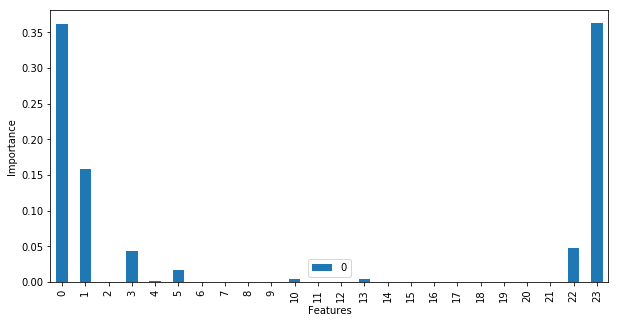

In [58]:
#データ2全ての説明変数を使用したデータ
y = df2["consume"].values

xcol = df2.columns.values

xcol = np.delete(xcol,1)
print("使用した説明変数")
print(xcol)

X = df2[xcol].values

ModelVerificationAdaboost(X, y, df2)